#### Import libraries

In [65]:
import kaos
import seaborn as sns
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import requests
from Bio import SeqIO
import time
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from pyensembl import EnsemblRelease
from genelocator import get_genelocator
import importlib
import tensorflow as tf
from keras.layers import Dense, LeakyReLU
from keras.initializers import he_normal
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall
import itertools
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix

#### Load the Data

In [66]:
# Open a FASTA file and iterate through the records
with open('GCF_000005845.2_ASM584v2_genomic.fna', 'r') as fasta_file:
    for record in SeqIO.parse(fasta_file, 'fasta'):
        print(record.id, len(record.seq))


NC_000913.3 4641652


In [67]:
public_data1 = pd.read_csv("example_data.csv")
public_data_phe = pd.read_csv("example_pheno.csv")

In [ ]:
# gisson_data= pd.read_csv("\Users\kaila\OneDrive\Desktop\FCGR_Gisson\cip_ctx_ctz_gen_multi_data")
# gisson_data1 = pd.read_csv("cip_ctx_ctz_gen_multi_data.csv")

In [ ]:
# gisson_data=gisson_data1.copy()
# gisson_data = gisson_data.replace({0: 'N', 1: 'A', 2: 'G', 3: 'C', 4: 'T'})

In [68]:
public_data_phe["CIP"].value_counts()

CIP
0    482
1    418
Name: count, dtype: int64

#### Decoding 'N', 'A', 'G', 'C' and 'T' with '0', '1', '2', '3' respectively 

In [69]:
public_data = public_data1.copy()
public_data =public_data.replace({0: 'N', 1: 'A', 2: 'G', 3: 'C', 4: 'T'})
public_data

,393,588,747,759,774,966,1299,1302,1407,1425,...,4640785,4640908,4640924,4641031,4641131,4641208,4641217,4641296,4641439,4641440
0,G,A,G,T,C,C,C,C,T,G,...,T,T,G,A,C,T,A,C,C,A
1,G,A,G,T,C,C,C,C,T,G,...,T,T,G,A,C,T,A,C,C,A
2,G,A,G,T,C,C,N,N,T,G,...,T,T,G,A,C,T,A,C,C,A
3,G,A,G,T,C,C,C,C,T,G,...,T,T,G,A,C,A,A,C,C,A
4,N,N,G,T,C,C,C,C,T,G,...,T,N,N,G,C,T,A,C,C,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,N,N,G,T,C,C,N,N,T,N,...,T,N,N,G,C,T,A,C,C,A
896,G,A,G,T,C,C,C,C,T,G,...,T,T,G,A,C,T,A,C,C,A
897,G,A,G,T,C,C,C,C,T,G,...,T,T,G,A,C,T,A,C,C,A
898,G,N,N,N,C,N,C,C,T,N,...,T,N,N,N,C,N,N,N,N,N


In [ ]:
# public_data2 = public_data1.copy()
# public_data2 = public_data2.replace({0: 'N', 1: 'A', 2: 'G', 3: 'C', 4: 'T'})
# public_data2

### Replace 'N' with the orginal reference nucleotide

In [70]:
for column_name in public_data.columns:
    seqq = record[int(column_name) - 1]
    public_data[column_name] = public_data[column_name].replace('N', seqq)

In [ ]:
public_data

### Concatenation of all the elements in each row converted to strings and write in 'ref' column

In [71]:
public_data["ref"] = ""

C:\Users\kaila\AppData\Local\Temp\ipykernel_17448\847315568.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  public_data["ref"] = ""


In [72]:
public_data["ref"] = public_data.apply(lambda row: ''.join(map(str, row)), axis=1)

In [ ]:
public_data

### Read the 'y' labels

In [73]:
y = public_data_phe["CIP"] 
y

0      0
1      1
2      0
3      0
4      1
      ..
895    1
896    1
897    1
898    1
899    1
Name: CIP, Length: 900, dtype: int64

In [ ]:
# public_data_con= public_data.copy()
# names_column = public_data_phe['prename']
# labels_column = public_data_phe['CIP']

# public_data_concat = pd.concat([names_column, public_data_con, labels_column], axis=1)

# public_data_concat


### Define kmer length, and generate kaos array 

In [74]:
kmer_length = 8
chaos_game_kmer_array = kaos.kaos_fcgr().chaos_game_representation_key(kmer_length=kmer_length)

In [75]:
chaos_game_kmer_array.shape

(256, 256)

In [ ]:
public_data.loc[i, "ref"]

### Generate embedding for each pattern and store it in'X'

In [76]:
X = list()

for i in range(public_data.shape[0]):
    print(i)
    X.append(kaos.kaos_fcgr().chaos_frequency_matrix(public_data.loc[i, "ref"], kmer_length= kmer_length, chaos_game_kmer_array=chaos_game_kmer_array)[0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
X[0].shape

### Split data into 'train' and 'test' set

In [77]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, test_size=0.2, stratify= y, random_state= 123)

### Define model and other parameters

In [79]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(filters=128, kernel_size=3))
model.add(MaxPooling1D(pool_size=4))
# model.add(BatchNormalization())
# model.add(Dropout(0.1))
# model.add(Conv1D(filters=64, kernel_size=3, kernel_regularizer=tf.keras.regularizers.L1(0.001)))
# model.add(Conv1D(filters=128, kernel_size=3))

# model.add(Conv1D(filters=128, kernel_size=3, kernel_regularizer=tf.keras.regularizers.L2(0.1)))

# model.add(Dropout(0.2))
# model.add(Conv1D(filters=64, kernel_size=3))
# model.add(MaxPooling1D(pool_size=4))
# model.add(Dropout(0.2))
model.add(Flatten())
# model.add(Dense(128, activation=LeakyReLU(alpha=0.01),kernel_initializer=he_normal(seed=0)))
model.add(Dropout(0.2))
model.add(Dense(256, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy', 'Precision', 'Recall'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 254, 64)           49216     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 63, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 61, 128)           24704     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 15, 128)           0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1920)              0         
                                                                 
 dropout_2 (Dropout)         (None, 1920)             

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(filters=128, kernel_size=3))
model.add(MaxPooling1D(pool_size=4))
# model.add(BatchNormalization())
# model.add(Dropout(0.1))
# model.add(Conv1D(filters=64, kernel_size=3, kernel_regularizer=tf.keras.regularizers.L1(0.001)))
# model.add(Conv1D(filters=128, kernel_size=3))

# model.add(Conv1D(filters=128, kernel_size=3, kernel_regularizer=tf.keras.regularizers.L2(0.1)))

# model.add(Dropout(0.2))
# model.add(Conv1D(filters=64, kernel_size=3))
# model.add(MaxPooling1D(pool_size=4))
# model.add(Dropout(0.2))
model.add(Flatten())
# model.add(Dense(128, activation=LeakyReLU(alpha=0.01),kernel_initializer=he_normal(seed=0)))
model.add(Dropout(0.2))
model.add(Dense(256, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy', 'Precision', 'Recall'])
model.summary()

In [ ]:
# import tensorflow as tf
# from keras.layers import Dense, LeakyReLU
# from keras.initializers import he_normal
# model = Sequential()
# model.add(Conv1D(filters=64, kernel_size=3, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(MaxPooling1D(pool_size=4))
# model.add(Conv1D(filters=128, kernel_size=3))
# model.add(MaxPooling1D(pool_size=8))
# # model.add(Dropout(0.2))
# model.add(Flatten())
# # model.add(Dense(128, activation=LeakyReLU(alpha=0.01),kernel_initializer=he_normal(seed=0)))
# model.add(Dropout(0.2))
# model.add(Dense(256, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy', 'Precision', 'Recall'])
# model.summary()

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(filters=128, kernel_size=3))
model.add(MaxPooling1D(pool_size=4))
# model.add(BatchNormalization())
# model.add(Dropout(0.1))
# model.add(Conv1D(filters=64, kernel_size=3, kernel_regularizer=tf.keras.regularizers.L1(0.001)))
# model.add(Conv1D(filters=128, kernel_size=3))

# model.add(Conv1D(filters=128, kernel_size=3, kernel_regularizer=tf.keras.regularizers.L2(0.1)))

# model.add(Dropout(0.2))
# model.add(Conv1D(filters=64, kernel_size=3))
# model.add(MaxPooling1D(pool_size=4))
# model.add(Dropout(0.2))
model.add(Flatten())
# model.add(Dense(128, activation=LeakyReLU(alpha=0.01),kernel_initializer=he_normal(seed=0)))
model.add(Dropout(0.2))
model.add(Dense(256, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy', 'Precision', 'Recall'])
model.summary()

### Train the model

In [81]:
history = model.fit(X_train, y_train, epochs=500, verbose=1, validation_split=0.2, batch_size=1500)

Epoch 1/500
1/1 [==============================] - 5s 5s/step - loss: 2.6625 - accuracy: 0.5486 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.7366 - val_accuracy: 0.4861 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/500
1/1 [==============================] - 1s 894ms/step - loss: 1.7345 - accuracy: 0.5365 - precision: 0.2941 - recall: 0.0192 - val_loss: 1.2552 - val_accuracy: 0.5139 - val_precision: 0.5139 - val_recall: 1.0000
Epoch 3/500
1/1 [==============================] - 1s 821ms/step - loss: 1.5076 - accuracy: 0.4670 - precision: 0.4511 - recall: 0.8346 - val_loss: 1.6046 - val_accuracy: 0.5139 - val_precision: 0.5139 - val_recall: 1.0000
Epoch 4/500
1/1 [==============================] - 1s 970ms/step - loss: 1.8341 - accuracy: 0.4566 - precision: 0.4526 - recall: 0.9731 - val_loss: 1.3546 - val_accuracy: 0.5139 - val_precision: 0.5139 - val_recall: 1.0000
Epoch 5/500
1/1 [==============================] - 1s 1s/step - loss: 1.6050 - accuracy: 0.4601

### Plot loss-matric curve and accuracy curve

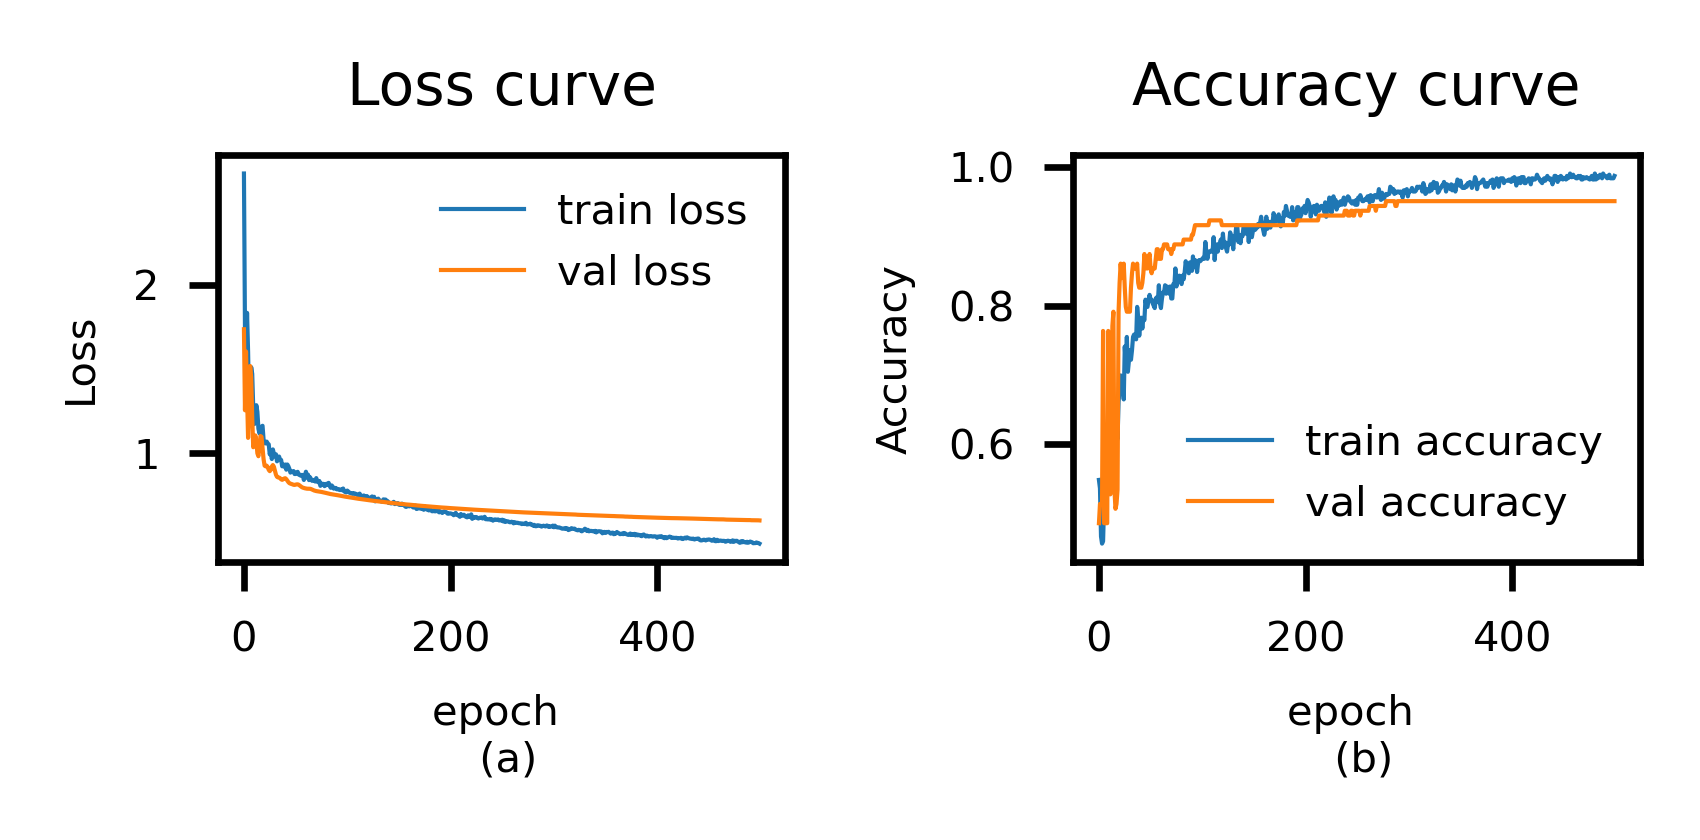

In [82]:
fig, ax= plt.subplots(1, 2, dpi =600, figsize = (3, 1.5))
ax[0].plot(history.history['loss'], label = "train loss", lw = 0.5)
ax[0].plot(history.history['val_loss'], label = "val loss", lw = 0.5)
ax[1].plot(history.history['accuracy'], label = "train accuracy", lw = 0.5)
ax[1].plot(history.history['val_accuracy'], label = "val accuracy", lw = 0.5)
ax[0].legend(fontsize=5, frameon=False)
ax[1].legend(fontsize=5, frameon=False)
ax[0].set_title("Loss curve", fontsize=7)
ax[1].set_title("Accuracy curve", fontsize=7)
ax[0].set_xlabel("epoch \n (a)", fontsize=5)
ax[1].set_xlabel("epoch \n (b)", fontsize=5)
ax[0].set_ylabel("Loss", fontsize=5)
ax[1].set_ylabel("Accuracy", fontsize=5)
ax[0].tick_params(axis='both', which='major', labelsize=5)
ax[1].tick_params(axis='both', which='major', labelsize=5)
# ax[0] = custom_figure_axis(ax[0], fontsize=5, show_ticks = True)
# ax[1] = custom_figure_axis(ax[1], fontsize=5, show_ticks = True)
plt.tight_layout()
# plt.savefig("Motif curve.pdf", dpi = 600)

### Normalized confusion matrix

6/6 [==============================] - 0s 16ms/step
Confusion matrix:
 [[92 10]
 [ 4 74]]


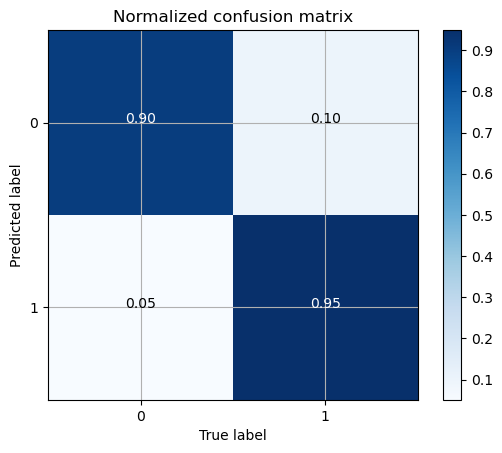

In [83]:
predicted_labels = model.predict(X_test)
cm = confusion_matrix(np.round(predicted_labels), y_test)
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] >= 0.5 else 'black')

### Matric result

In [84]:
print("The accuracy of test set is ", accuracy_score(np.round(predicted_labels), y_test))
print("The precision of test set is ",  precision_score(np.round(predicted_labels), y_test))
print("The recall of test set is ", recall_score(np.round(predicted_labels), y_test))
print("The f1 of test set is ",  f1_score(np.round(predicted_labels), y_test))
print("The ROC_AUC of test set is ", roc_auc_score(np.round(predicted_labels), y_test))
print("The cohen kappa of test set is ", cohen_kappa_score(np.round(predicted_labels), y_test))


The accuracy of test set is  0.9222222222222223
The precision of test set is  0.8809523809523809
The recall of test set is  0.9487179487179487
The f1 of test set is  0.9135802469135802
The ROC_AUC of test set is  0.925339366515837
The cohen kappa of test set is  0.8430493273542601
